In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import torchvision
from torch.utils.data import TensorDataset, random_split, DataLoader
import torch.nn as nn
import time
import wandb
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import SMOTE
import torch
from datetime import datetime
from collections import OrderedDict
from sklearn.decomposition import PCA
import flwr as fl
from flwr.common import Metrics 
from time import gmtime, strftime
from flwr.server.strategy import FedAvg, FedAdagrad, FedProx
from flwr.common import ndarrays_to_parameters, NDArrays, Scalar, Context

now = datetime.now() # current date and time
date_time = now.strftime("%d-%m-%Y_%H:%M:%S")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using {device}.')

Using cuda.


In [2]:
wandb.init(
    # set the wandb project where this run will be logged
    project="FTL unified",
    name= "5 parts_{}".format(date_time),
    # track hyperparameters and run metadata
    config={
    "learning_rate": 0.0001,
    "architecture": "CNN",
    "epochs": 100,
    "batch_size": 64,
    "decay":0,
    'dropout': 0.001,
    "learning_rate_FL": 0.0001,
    "batch_size_FL": 64,
    "decay_FL": 1e-5,
    'num_rounds_FL': 100, 
    'epochs_FL': 100,
    'dropout_FL': 0.001
    }
)

configuration  = dict(wandb.config)


def data_loading_AZURE(data_paths, label_paths, batch_size, train_ratio=0.8, val_ratio=0.05, transfer_ratio= 0.4):
    trainloader = []
    valloader = []
    traindata_list = []
    trainlabel_list = []
    valdata_list = []
    vallabel_list = []
    testdata_list = []
    testlabels_list = []
    for i in range(len(data_paths)):
        # importing from paths
        data = torch.load(data_paths[i])
        labels = torch.load(label_paths[i])
        data = nn.functional.normalize(data, dim=1)
        # reshaping the dataset so  the channels will be the second dimension.
        data = data.permute(0, 2, 1)
        n_samples, n_channels, n_features = data.shape
        X_reshaped = data.reshape(n_samples, -1) 
        # Apply SMOTE
        smote = SMOTE(sampling_strategy='minority')
        data_resampled, labels_resampled = smote.fit_resample(X_reshaped, labels)
        # Reshape X_resampled back to 3D
        data_resampled = data_resampled.reshape(-1, n_channels, n_features)
        data_resampled = torch.tensor(data_resampled)
        labels_resampled = torch.tensor(labels_resampled)
        dataset = TensorDataset(data_resampled, labels_resampled)
        test_ratio = 1 - (train_ratio + val_ratio)
        print(test_ratio)
        test_size = int(test_ratio * len(dataset))
        print(test_size)
        transfer_size = int((len(dataset) - test_size)*transfer_ratio)
        train_size_t = int(train_ratio * transfer_size)
        val_size_t = transfer_size - train_size_t
        centralized_size = len(dataset) - (transfer_size + test_size)
        train_size = int(centralized_size * train_ratio)
        val_size = centralized_size - train_size

        train_dataset, val_dataset, test_dataset, train_dataset_transfer, val_dataset_transfer = random_split(dataset, [train_size, val_size, test_size, train_size_t, val_size_t])

        trainloader.append(DataLoader(train_dataset, batch_size=batch_size, shuffle=True))
        valloader.append(DataLoader(val_dataset, batch_size=batch_size, shuffle=True))

        traindata_list.append(train_dataset_transfer.dataset.tensors[0][train_dataset_transfer.indices])
        trainlabel_list.append(train_dataset_transfer.dataset.tensors[1][train_dataset_transfer.indices])
        valdata_list.append(val_dataset_transfer.dataset.tensors[0][val_dataset_transfer.indices])
        vallabel_list.append(val_dataset_transfer.dataset.tensors[1][val_dataset_transfer.indices])
        testdata_list.append(test_dataset.dataset.tensors[0][test_dataset.indices])
        testlabels_list.append(test_dataset.dataset.tensors[1][test_dataset.indices])

    traindata = torch.cat(traindata_list, dim=0)
    trainlabels = torch.cat(trainlabel_list, dim=0)
    valdata = torch.cat(valdata_list, dim=0)
    vallabels = torch.cat(vallabel_list, dim=0)
    testdata = torch.cat(testdata_list, dim=0)
    testlabels = torch.cat(testlabels_list, dim=0)
    
    # Create a DataLoader for the combined test data
    trainloader_transfer = DataLoader(TensorDataset(traindata, trainlabels), batch_size=batch_size, shuffle=False)
    valloader_transfer = DataLoader(TensorDataset(valdata, vallabels), batch_size=batch_size, shuffle=False)
    testloader = DataLoader(TensorDataset(testdata, testlabels), batch_size=batch_size, shuffle=False)
    
    return trainloader, valloader, testloader, trainloader_transfer, valloader_transfer

def data_loading_NASA(data_path, label_path, batch_size, train_ratio=0.8, val_ratio = 0.5):
    data = torch.load(data_path)
    labels = torch.load(label_path)
    data = nn.functional.normalize(data, dim=1)
    # reshaping the dataset so  the channels will be the second dimension.
    data = data.permute(0, 2, 1)
    print(data.size())

    def pca_reduction(data, n_components=4):
        data_reshaped = data.reshape(-1, data.shape[1])

        # Apply PCA
        pca = PCA(n_components=n_components)
        
        data_reduced = pca.fit_transform(data_reshaped)

        # Reshape back to (samples, n_components, time_steps)
        data_reduced = data_reduced.reshape(data.shape[0], n_components, data.shape[2])

        return data_reduced
    print(data.dtype)
    data = pca_reduction(data, n_components=4)
    data =(torch.from_numpy(data)).float()
    n_samples, n_channels, n_features = data.shape
    X_reshaped = data.reshape(n_samples, -1) 
    
    n_samples, n_channels, n_features = data.shape
    X_reshaped = data.reshape(n_samples, -1) 
    
    # Apply SMOTE
    smote = SMOTE(sampling_strategy='minority')
    data_resampled, labels_resampled = smote.fit_resample(X_reshaped, labels)
    print((labels_resampled==1).sum())
    # Reshape X_resampled back to 3D
    data_resampled = data_resampled.reshape(-1, n_channels, n_features)
    print(data_resampled.shape)
    data_resampled = torch.tensor(data_resampled)
    labels_resampled = torch.tensor(labels_resampled)
    dataset = TensorDataset(data_resampled, labels_resampled)
    train_size = int(train_ratio * len(dataset))
    test_size = len(dataset) - train_size
    val_size = int(val_ratio * test_size)
    test_size = test_size - val_size
    train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])
    return DataLoader(train_dataset, batch_size=batch_size, shuffle=True), DataLoader(val_dataset, batch_size=batch_size, shuffle=True), DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


wandb: Currently logged in as: d-hadjikazemi (d-hadjikazemi-queen-mary-university-of-london). Use `wandb login --relogin` to force relogin
/home/diba/miniconda3/envs/FTL/lib/python3.10/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


In [3]:
# Define the CNN architecture
class Neural_Network(nn.Module):
    def __init__(self):
        super(Neural_Network, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=4, out_channels=8, kernel_size=5)
        self.bn1 = nn.BatchNorm1d(8)
        self.conv2 = nn.Conv1d(in_channels=8, out_channels=8, kernel_size=5)
        self.bn2 = nn.BatchNorm1d(8)
        self.pool = nn.MaxPool1d(kernel_size=2, padding=0, stride=1)
        # the size of the out channels x number  of nodes 
        self.fc1 = nn.Linear(328, 200)
        self.fc2 = nn.Linear(200, 2)
        self.flatten = nn.Flatten()
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(configuration['dropout'])
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # x = self.relu(self.conv1(x))
        # x = self.relu(self.conv2(x))
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.dropout(x)
        x = self.pool(x)
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x - self.dropout(x)
        x = self.sigmoid(self.fc2(x))
        return x

In [4]:
def correct(logits, y):
    y_hat = logits.argmax(axis=1) # Finds the column with the highest value for each row of `logits`.
    return (y_hat == y).float().sum() # Computes the number of times that `y_hat` and `y` match.

def evaluate_metric(model, data_iter, metric):
    """Compute the average `metric` of the model on a dataset."""
    c = torch.tensor(0.).to(device)
    n = torch.tensor(0.).to(device)
    for X, y in data_iter:
        X, y = X.to(device), y.to(device) # Moves data to `device`
        logits = model(X)
        c += metric(logits, y)
        n += len(y)
    return c*100 / n


In [5]:
def train(model, train_loaders,test_loader, config, epochs):
    loss = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=config['learning_rate'], weight_decay=config['decay'])
    losses = [] # Stores the loss for each training batch
    train_accs = [] # Stores the training accuracy after each epoch
    test_accs = []
    for epoch in range(epochs):
        print(f'\nEpoch {epoch + 1}/{epochs}')
        total, epoch_loss = 0, 0.0
        model.train() # This is necessary because batch normalization behaves differently between training and evaluation
        
        for X, y in train_loaders:
            X, y = X.to(device), y.to(device) # Moves data to `device`
            logits = model(X) # Computes the logits for the batch of images `X`
            l = loss(logits, y) # Computes the loss given the `logits` and the class vector `y`
            optimizer.zero_grad() # Zeroes the gradients stored in the model parameters
            l.backward() # Computes the gradient of the loss `l` with respect to the model parameters

            optimizer.step() # Updates the model parameters based on the gradients stored inside them
            epoch_loss += l
            
        model.eval() # This is necessary because batch normalization behaves differently between training and evaluation
        train_acc = evaluate_metric(model, train_loaders, correct)
        train_accs.append(train_acc)
        test_acc = evaluate_metric(model, test_loader, correct)
        test_accs.append(test_acc)
        print(f'Epoch {epoch+1}: Training accuracy: {train_accs[-1]} Testing accuracy: {test_accs[-1]}.') # Computes and displays training/testing dataset accuracy.
    plt.plot(list(map(lambda x: x.cpu(),train_accs)), label='Training accuracy')
    plt.plot(list(map(lambda x: x.cpu(),test_accs)), label='Validation accuracy')
    plt.title('accuracies')
    plt.legend()

def test(model, test_loaders,  configuration):
    loss = nn.CrossEntropyLoss()
    test_accs = []
    optimizer = torch.optim.Adam(model.parameters(), lr=configuration['learning_rate'], weight_decay=configuration['decay'])
    test_acc = []
    l = 0.0
    model.eval() # This is necessary because batch normalization behaves differently between training and evaluation
    for X, y in test_loaders:    
        X, y = X.to(device), y.to(device) # Moves data to `device`
        logits = model(X)
        l = loss(logits, y).item()
        test_acc = evaluate_metric(model, test_loaders, correct)
        test_accs.append(test_acc)
        
        # wandb.log({"test_acc": test_acc})
        l /= len(test_loaders)
        end_time = time.perf_counter()
        # print('Testing accuracy: {test_accs[-1]}.')
        return l, test_acc

NASA = data_loading_NASA(data_path='NASA_data_50.pt', label_path= 'NASA_label_50.pt', batch_size= configuration['batch_size'])

torch.Size([848, 24, 50])
torch.float32
685
(1370, 4, 50)



Epoch 1/100
Epoch 1: Training accuracy: 48.9963493347168 Testing accuracy: 56.20438003540039.

Epoch 2/100
Epoch 2: Training accuracy: 55.20072937011719 Testing accuracy: 47.445255279541016.

Epoch 3/100
Epoch 3: Training accuracy: 59.215328216552734 Testing accuracy: 43.79561996459961.

Epoch 4/100
Epoch 4: Training accuracy: 59.580291748046875 Testing accuracy: 48.1751823425293.

Epoch 5/100
Epoch 5: Training accuracy: 65.41970825195312 Testing accuracy: 44.52554702758789.

Epoch 6/100
Epoch 6: Training accuracy: 63.68613052368164 Testing accuracy: 45.25547409057617.

Epoch 7/100
Epoch 7: Training accuracy: 65.78466796875 Testing accuracy: 50.36496353149414.

Epoch 8/100
Epoch 8: Training accuracy: 67.88320922851562 Testing accuracy: 51.09489059448242.

Epoch 9/100
Epoch 9: Training accuracy: 66.51459503173828 Testing accuracy: 50.36496353149414.

Epoch 10/100
Epoch 10: Training accuracy: 67.06204223632812 Testing accuracy: 49.63503646850586.

Epoch 11/100
Epoch 11: Training accurac

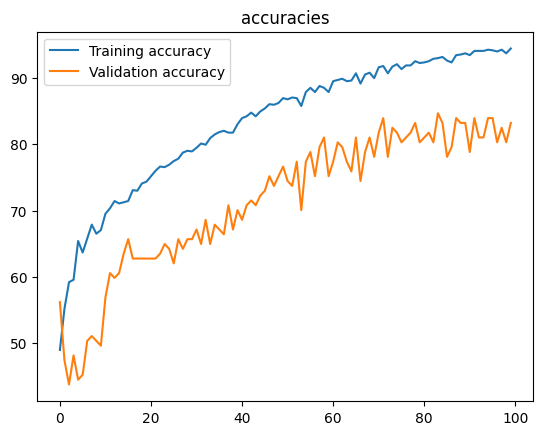

In [6]:
trainloader = NASA[0]
valloader = NASA[1]
testloader = NASA[2]
net = Neural_Network().to(device)
losses = []
accuracies = []
for epoch in range(1):
    train(net, trainloader, valloader, configuration, configuration['epochs'])
    loss, accuracy = test(net, valloader, configuration)
    losses.append(loss)
    accuracies.append(int(accuracy))
    print(f"Epoch {epoch+1}: validation loss {loss}, accuracy {accuracy}")
# plt.plot(accuracies)
loss, accuracy = test(net, testloader, configuration=configuration)

print(f"Final test set performance:\n\tloss {loss}\n\taccuracy {accuracy}")

## transfer learning

In [7]:
azure_data_paths = ['AZURE_data_1.pt', 'AZURE_data_2.pt','AZURE_data_3.pt','AZURE_data_4.pt']
azure_label_paths = ['AZURE_label_1.pt','AZURE_label_2.pt','AZURE_label_3.pt','AZURE_label_4.pt']
azure_train_loaders, azure_val_loaders, azure_test_loader, azure_train_loaders_transfer, azure_val_loaders_transfer = data_loading_AZURE(azure_data_paths, azure_label_paths, batch_size=configuration['batch_size_FL'])

0.1499999999999999
250
0.1499999999999999
233
0.1499999999999999
310
0.1499999999999999
253



Epoch 1/100
Epoch 1: Training accuracy: 51.05263137817383 Testing accuracy: 53.99159622192383.

Epoch 2/100
Epoch 2: Training accuracy: 58.31578826904297 Testing accuracy: 60.29411697387695.

Epoch 3/100
Epoch 3: Training accuracy: 62.05263137817383 Testing accuracy: 62.81512451171875.

Epoch 4/100
Epoch 4: Training accuracy: 64.57894897460938 Testing accuracy: 64.28571319580078.

Epoch 5/100
Epoch 5: Training accuracy: 67.7368392944336 Testing accuracy: 65.75630187988281.

Epoch 6/100
Epoch 6: Training accuracy: 69.47368621826172 Testing accuracy: 67.64705657958984.

Epoch 7/100
Epoch 7: Training accuracy: 70.84210205078125 Testing accuracy: 67.43697357177734.

Epoch 8/100
Epoch 8: Training accuracy: 72.84210205078125 Testing accuracy: 69.5378189086914.

Epoch 9/100
Epoch 9: Training accuracy: 73.7368392944336 Testing accuracy: 72.05882263183594.

Epoch 10/100
Epoch 10: Training accuracy: 75.0526351928711 Testing accuracy: 72.68907928466797.

Epoch 11/100
Epoch 11: Training accuracy:

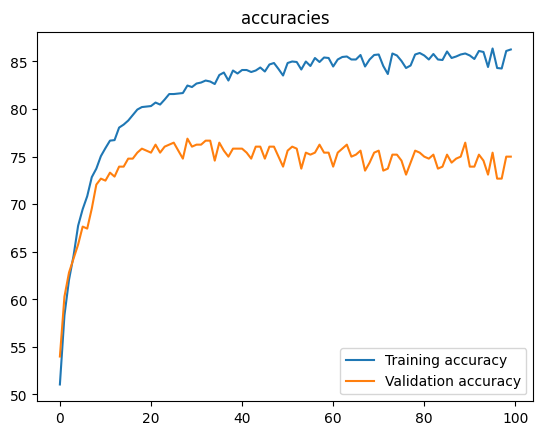

In [8]:
losses_transfer = []
accuracies_transfer = []
for epoch in range(1):
    train(net, azure_train_loaders_transfer, azure_val_loaders_transfer, configuration, configuration['epochs'])
    loss, accuracy = test(net, azure_val_loaders_transfer, configuration)
    losses_transfer.append(loss)
    accuracies_transfer.append(int(accuracy))
    print(f"Epoch {epoch+1}: validation loss {loss}, accuracy {accuracy}")
# plt.plot(accuracies)
losses_transfer, accuracy_transfer = test(net, testloader, configuration=configuration)

print(f"Final test set performance:\n\tloss {loss}\n\taccuracy {accuracy}")

trainloader = train_loaders[1]
valloader = val_loaders[1]
testloader = test_loaders[1]
net = Neural_Network().to(device)
losses = []
accuracies = []
for epoch in range(1):
    train(net, trainloader, testloader, configuration, configuration['epochs'])
    loss, accuracy = test(net, valloader, configuration)
    losses.append(loss)
    accuracies.append(int(accuracy))
    print(f"Epoch {epoch+1}: validation loss {loss}, accuracy {accuracy}")
<!-- # plt.plot(accuracies) -->
loss, accuracy = test(net, testloader, configuration=configuration)
print(f"Final test set performance:\n\tloss {loss}\n\taccuracy {accuracy}")

## Federated Learning

In [9]:
# Define the CNN architecture
class Neural_Network_FL(nn.Module):
    def __init__(self):
        super(Neural_Network_FL, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=4, out_channels=8, kernel_size=5)
        self.conv2 = nn.Conv1d(in_channels=8, out_channels=8, kernel_size=5)
        self.pool = nn.MaxPool1d(kernel_size=2, padding=0, stride=1)
        # the size of the out channels x number  of nodes 
        self.fc1 = nn.Linear(328, 200)
        self.fc2 = nn.Linear(200, 2)
        self.flatten = nn.Flatten()
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(configuration['dropout'])
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.dropout(x)
        x = self.pool(x)
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x - self.dropout(x)
        x = self.sigmoid(self.fc2(x))
        return x

In [10]:
def get_parameters(model):
    # Return model parameters as a list of NumPy ndarrays, excluding parameters of BN layers when using FedBN
    return [val.cpu().numpy() for name, val in model.state_dict().items() if ('bn1' not in name and 'bn2' not in name)]

def set_parameters(model, parameters):
    # Set model parameters from a list of NumPy ndarrays
    keys = [k for k in model.state_dict().keys() if 'bn' not in k]
    params_dict = zip(keys, parameters)
    state_dict = OrderedDict({k: torch.tensor(v) for k, v in params_dict})
    model.load_state_dict(state_dict, strict=False)

net_FL = Neural_Network_FL().to(device)
parameters_centralized = get_parameters(net)
set_parameters(net_FL, parameters_centralized)

In [11]:
class FlowerClient(fl.client.NumPyClient):
    def __init__(self, net, trainloader, valloader, configuration):
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader

    def get_parameters(self, config):
        return get_parameters(self.net)

    def fit(self, parameters, config):
        set_parameters(self.net, parameters)
        train(self.net, self.trainloader,self.valloader,configuration, configuration['epochs_FL'])
        return get_parameters(self.net), len(self.trainloader), {}

    def evaluate(self, parameters, config):
        set_parameters(self.net, parameters)
        loss, accuracy = test(self.net, self.valloader, configuration)
        return float(loss), len(self.valloader), {"accuracy": float(accuracy)}
    

def client_fn(cid) -> FlowerClient:
    net = Neural_Network().to(device)
    trainloader = azure_train_loaders[int(cid)]
    valloader = azure_val_loaders[int(cid)]
    return FlowerClient(net_FL, trainloader, valloader, configuration).to_client()


In [12]:
# client will be allocated 1x CPU and 0x GPUs
if device.type == 'cuda':
    # here we are assigning an entire GPU for each client.
    client_resources = {"num_cpus": 1, "num_gpus": 1.0}
    # Refer to our documentation for more details about Flower Simulations
    # and how to setup these `client_resources`.
    
# The `evaluate` function will be called by Flower after every round
fl_acc = []
def evaluate(server_round,parameters,config,):
    testloader = azure_test_loader
    set_parameters(net_FL, parameters)  # Update model with the latest parameters
    loss, accuracy = test(net_FL, testloader, configuration)
    print(f"Server-side evaluation loss {loss} / accuracy {accuracy}")
    fl_acc.append(accuracy)
    metrics = {'FL loss': loss,
               "FL accuracy": accuracy}
    wandb.log(metrics)
    return loss, {"accuracy": accuracy}

def weighted_average(metrics):
    # Multiply accuracy of each client by number of examples used
    accuracies = [num_examples * m["accuracy"] for num_examples, m in metrics]
    examples = [num_examples for num_examples, _ in metrics]

    # Aggregate and return custom metric (weighted average)
    return {"accuracy": sum(accuracies) / sum(examples)}
params = get_parameters(net_FL)
strategy = fl.server.strategy.FedAvg(
    fraction_fit=1,
    fraction_evaluate=0.5,
    min_fit_clients=2,
    min_evaluate_clients=1,
    min_available_clients=1,
    evaluate_fn=evaluate,
    initial_parameters= ndarrays_to_parameters(params),
    evaluate_metrics_aggregation_fn=weighted_average # <-- pass the metric aggregation function
)
# Start simulation
history = fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=4,
    config=fl.server.ServerConfig(num_rounds=configuration['num_rounds_FL']),
    strategy=strategy,
    client_resources=client_resources,
)

Setting `min_available_clients` lower than `min_fit_clients` or
`min_evaluate_clients` can cause the server to fail when there are too few clients
connected to the server. `min_available_clients` must be set to a value larger
than or equal to the values of `min_fit_clients` and `min_evaluate_clients`.

INFO :      Starting Flower simulation, config: num_rounds=100, no round_timeout
2024-08-12 10:45:13,928	INFO worker.py:1621 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'CPU': 32.0, 'object_store_memory': 58281440870.0, 'node:192.168.1.146': 1.0, 'memory': 125990028698.0, 'node:__internal_head__': 1.0, 'accelerator_type:G': 1.0, 'GPU': 2.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      Flower VCE: Resources for each Virtual Client: {'num_cpus': 1, 'num_gpus': 1.0}
INFO :      Flower VCE: Creating VirtualClientEngineActorPool with 2 actors
INFO :      [INIT]
INFO 

Server-side evaluation loss 0.04951255812364466 / accuracy 48.9483757019043
(ClientAppActor pid=2226288) 
(ClientAppActor pid=2226288) Epoch 1/100
(ClientAppActor pid=2226287) Epoch 1: Training accuracy: 50.36710739135742 Testing accuracy: 46.198829650878906.
(ClientAppActor pid=2226287) Epoch 2: Training accuracy: 50.36710739135742 Testing accuracy: 46.198829650878906.


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (1, 0.041037541978499466, {'accuracy': tensor(48.9484, device='cuda:0')}, 4.6689589460147545)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.041037541978499466 / accuracy 48.9483757019043
(ClientAppActor pid=2226288)  [repeated 604x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/ray-logging.html#log-deduplication for more options.)
(ClientAppActor pid=2226288) Epoch 15/100 [repeated 604x across cluster]
(ClientAppActor pid=2226288) Epoch 22: Training accuracy: 51.96232223510742 Testing accuracy: 50.625. [repeated 615x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (2, 0.040974683621350455, {'accuracy': tensor(48.9484, device='cuda:0')}, 7.839910870068707)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.040974683621350455 / accuracy 48.9483757019043


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (3, 0.04084171617732329, {'accuracy': tensor(53.4417, device='cuda:0')}, 11.017956758034416)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.04084171617732329 / accuracy 53.441680908203125
(ClientAppActor pid=2226288)  [repeated 640x across cluster]
(ClientAppActor pid=2226288) Epoch 29/100 [repeated 640x across cluster]
(ClientAppActor pid=2226288) Epoch 35: Training accuracy: 52.11930847167969 Testing accuracy: 50.625. [repeated 639x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (4, 0.04086611551396987, {'accuracy': tensor(56.4054, device='cuda:0')}, 14.158185450010933)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.04086611551396987 / accuracy 56.40535354614258
(ClientAppActor pid=2226288)  [repeated 673x across cluster]
(ClientAppActor pid=2226288) Epoch 69/100 [repeated 673x across cluster]
(ClientAppActor pid=2226288) Epoch 76: Training accuracy: 72.0565185546875 Testing accuracy: 70.0. [repeated 674x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (5, 0.04048906704958748, {'accuracy': tensor(66.9216, device='cuda:0')}, 17.341988409054466)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.04048906704958748 / accuracy 66.9216079711914


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (6, 0.03968727939269122, {'accuracy': tensor(68.3556, device='cuda:0')}, 20.412326805992052)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.03968727939269122 / accuracy 68.35564422607422
(ClientAppActor pid=2226288)  [repeated 643x across cluster]
(ClientAppActor pid=2226288) Epoch 84/100 [repeated 643x across cluster]
(ClientAppActor pid=2226288) Epoch 90: Training accuracy: 67.25403594970703 Testing accuracy: 68.42105102539062. [repeated 642x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (7, 0.03927895952673519, {'accuracy': tensor(68.3556, device='cuda:0')}, 23.6974048219854)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.03927895952673519 / accuracy 68.35564422607422
(ClientAppActor pid=2226288)  [repeated 621x across cluster]
(ClientAppActor pid=2226288) Epoch 82/100 [repeated 621x across cluster]
(ClientAppActor pid=2226288) Epoch 88: Training accuracy: 69.13043212890625 Testing accuracy: 68.78612518310547. [repeated 616x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (8, 0.039250531617332905, {'accuracy': tensor(68.0688, device='cuda:0')}, 27.010721786064096)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.039250531617332905 / accuracy 68.06883239746094


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (9, 0.038811154225293326, {'accuracy': tensor(68.2600, device='cuda:0')}, 30.2824385400163)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 10]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.038811154225293326 / accuracy 68.26004028320312
(ClientAppActor pid=2226288)  [repeated 620x across cluster]
(ClientAppActor pid=2226288) Epoch 5/100 [repeated 620x across cluster]
(ClientAppActor pid=2226288) Epoch 11: Training accuracy: 69.71014404296875 Testing accuracy: 71.67630004882812. [repeated 623x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (10, 0.0382733099600848, {'accuracy': tensor(69.1205, device='cuda:0')}, 33.52925741102081)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 11]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.0382733099600848 / accuracy 69.1204605102539


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (11, 0.03777405444313498, {'accuracy': tensor(69.0249, device='cuda:0')}, 36.759897813084535)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 12]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.03777405444313498 / accuracy 69.02485656738281
(ClientAppActor pid=2226288)  [repeated 601x across cluster]
(ClientAppActor pid=2226288) Epoch 3/100 [repeated 601x across cluster]
(ClientAppActor pid=2226288) Epoch 10: Training accuracy: 72.68445587158203 Testing accuracy: 69.375. [repeated 600x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (12, 0.03821747793870814, {'accuracy': tensor(70.2677, device='cuda:0')}, 39.969633977045305)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 13]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.03821747793870814 / accuracy 70.26768493652344
(ClientAppActor pid=2226288)  [repeated 635x across cluster]
(ClientAppActor pid=2226288) Epoch 33/100 [repeated 635x across cluster]
(ClientAppActor pid=2226288) Epoch 39: Training accuracy: 72.17391204833984 Testing accuracy: 69.94219970703125. [repeated 640x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (13, 0.03690511338851031, {'accuracy': tensor(70.3633, device='cuda:0')}, 43.067543687997386)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 14]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.03690511338851031 / accuracy 70.36328887939453


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (14, 0.03649711608886719, {'accuracy': tensor(70.5545, device='cuda:0')}, 46.25704485701863)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 15]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.03649711608886719 / accuracy 70.55449676513672
(ClientAppActor pid=2226288)  [repeated 636x across cluster]
(ClientAppActor pid=2226288) Epoch 44/100 [repeated 636x across cluster]
(ClientAppActor pid=2226288) Epoch 50: Training accuracy: 70.72463989257812 Testing accuracy: 71.0982666015625. [repeated 634x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (15, 0.036313926472383386, {'accuracy': tensor(70.5545, device='cuda:0')}, 49.375236422987655)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 16]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.036313926472383386 / accuracy 70.55449676513672
(ClientAppActor pid=2226288)  [repeated 666x across cluster]
(ClientAppActor pid=2226288) Epoch 61/100 [repeated 666x across cluster]
(ClientAppActor pid=2226288) Epoch 65: Training accuracy: 76.30331420898438 Testing accuracy: 67.92453002929688. [repeated 666x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (16, 0.03611676482593312, {'accuracy': tensor(71.3193, device='cuda:0')}, 52.66967208101414)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 17]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.03611676482593312 / accuracy 71.3193130493164


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (17, 0.035599224707659555, {'accuracy': tensor(70.9369, device='cuda:0')}, 55.78819623403251)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 18]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.035599224707659555 / accuracy 70.93690490722656
(ClientAppActor pid=2226288)  [repeated 597x across cluster]
(ClientAppActor pid=2226288) Epoch 63/100 [repeated 597x across cluster]
(ClientAppActor pid=2226288) Epoch 68: Training accuracy: 77.36966705322266 Testing accuracy: 68.86792755126953. [repeated 598x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (18, 0.03589479712878957, {'accuracy': tensor(72.6577, device='cuda:0')}, 58.94051943602972)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 19]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.03589479712878957 / accuracy 72.65774536132812


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (19, 0.03603058352189906, {'accuracy': tensor(72.5621, device='cuda:0')}, 62.10988914198242)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 20]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


(ClientAppActor pid=2226287)  [repeated 659x across cluster]
(ClientAppActor pid=2226287) Epoch 96/100 [repeated 659x across cluster]
Server-side evaluation loss 0.03603058352189906 / accuracy 72.56214141845703
(ClientAppActor pid=2226287) Epoch 100: Training accuracy: 74.49275207519531 Testing accuracy: 73.98844146728516. [repeated 651x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (20, 0.03505601251826567, {'accuracy': tensor(72.4665, device='cuda:0')}, 65.3704409210477)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 21]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.03505601251826567 / accuracy 72.46653747558594
(ClientAppActor pid=2226288)  [repeated 632x across cluster]
(ClientAppActor pid=2226288) Epoch 14/100 [repeated 632x across cluster]
(ClientAppActor pid=2226288) Epoch 20: Training accuracy: 76.23188781738281 Testing accuracy: 75.1445083618164. [repeated 638x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (21, 0.03473745023503023, {'accuracy': tensor(72.8489, device='cuda:0')}, 68.57230967003852)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 22]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.03473745023503023 / accuracy 72.84894561767578


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (22, 0.034545281354118794, {'accuracy': tensor(72.8489, device='cuda:0')}, 71.68659017898608)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 23]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.034545281354118794 / accuracy 72.84894561767578
(ClientAppActor pid=2226288)  [repeated 628x across cluster]
(ClientAppActor pid=2226288) Epoch 34/100 [repeated 628x across cluster]
(ClientAppActor pid=2226287) Epoch 28: Training accuracy: 76.81159210205078 Testing accuracy: 74.56647491455078. [repeated 623x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (23, 0.03441432994954726, {'accuracy': tensor(73.3270, device='cuda:0')}, 74.92515332007315)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 24]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.03441432994954726 / accuracy 73.32695770263672
(ClientAppActor pid=2226288)  [repeated 641x across cluster]
(ClientAppActor pid=2226288) Epoch 38/100 [repeated 641x across cluster]
(ClientAppActor pid=2226288) Epoch 37: Training accuracy: 76.7660903930664 Testing accuracy: 75.0. [repeated 634x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (24, 0.03438063228831572, {'accuracy': tensor(73.7094, device='cuda:0')}, 78.0891539810691)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 25]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.03438063228831572 / accuracy 73.70936584472656


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (25, 0.0338901912464815, {'accuracy': tensor(72.9445, device='cuda:0')}, 81.18592586100567)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 26]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.0338901912464815 / accuracy 72.94454956054688
(ClientAppActor pid=2226288)  [repeated 664x across cluster]
(ClientAppActor pid=2226288) Epoch 79/100 [repeated 664x across cluster]
(ClientAppActor pid=2226288) Epoch 78: Training accuracy: 76.94567108154297 Testing accuracy: 74.85379791259766. [repeated 664x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (26, 0.0340194491779103, {'accuracy': tensor(74.2830, device='cuda:0')}, 84.55807090108283)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 27]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.0340194491779103 / accuracy 74.2829818725586
(ClientAppActor pid=2226288)  [repeated 606x across cluster]
(ClientAppActor pid=2226288) Epoch 99/100 [repeated 606x across cluster]
(ClientAppActor pid=2226288) Epoch 98: Training accuracy: 78.49293518066406 Testing accuracy: 73.75. [repeated 606x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (27, 0.03406390021829044, {'accuracy': tensor(74.5698, device='cuda:0')}, 87.8347384360386)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 28]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.03406390021829044 / accuracy 74.56978607177734


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (28, 0.033613930730258715, {'accuracy': tensor(71.9885, device='cuda:0')}, 90.93854388105683)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 29]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.033613930730258715 / accuracy 71.988525390625
(ClientAppActor pid=2226288)  [repeated 631x across cluster]
(ClientAppActor pid=2226288) Epoch 4/100 [repeated 631x across cluster]
(ClientAppActor pid=2226288) Epoch 3: Training accuracy: 79.3838882446289 Testing accuracy: 73.11320495605469. [repeated 631x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (29, 0.03395822468925925, {'accuracy': tensor(75.0478, device='cuda:0')}, 94.1622539490927)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 30]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.03395822468925925 / accuracy 75.04779815673828


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (30, 0.03373304535360897, {'accuracy': tensor(74.2830, device='cuda:0')}, 97.48403474804945)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 31]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


(ClientAppActor pid=2226288)  [repeated 602x across cluster]
(ClientAppActor pid=2226288) Epoch 100/100 [repeated 602x across cluster]
(ClientAppActor pid=2226288) Epoch 100: Training accuracy: 79.4419937133789 Testing accuracy: 76.60818481445312. [repeated 604x across cluster]
Server-side evaluation loss 0.03373304535360897 / accuracy 74.2829818725586


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (31, 0.033916518968694354, {'accuracy': tensor(75.2390, device='cuda:0')}, 100.62230570300017)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 32]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.033916518968694354 / accuracy 75.23900604248047
(ClientAppActor pid=2226288)  [repeated 658x across cluster]
(ClientAppActor pid=2226288) Epoch 23/100 [repeated 658x across cluster]
(ClientAppActor pid=2226288) Epoch 22: Training accuracy: 77.13269805908203 Testing accuracy: 69.81131744384766. [repeated 656x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (32, 0.033845694626078886, {'accuracy': tensor(75.2390, device='cuda:0')}, 104.02363142103422)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 33]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.033845694626078886 / accuracy 75.23900604248047


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (33, 0.03497405613169951, {'accuracy': tensor(74.3786, device='cuda:0')}, 107.28209228499327)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 34]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.03497405613169951 / accuracy 74.37858581542969
(ClientAppActor pid=2226288)  [repeated 569x across cluster]
(ClientAppActor pid=2226288) Epoch 17/100 [repeated 569x across cluster]
(ClientAppActor pid=2226288) Epoch 16: Training accuracy: 77.09251403808594 Testing accuracy: 74.26900482177734. [repeated 569x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (34, 0.0339425381492166, {'accuracy': tensor(75.4302, device='cuda:0')}, 110.57250206707977)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 35]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.0339425381492166 / accuracy 75.43021392822266
(ClientAppActor pid=2226288)  [repeated 635x across cluster]
(ClientAppActor pid=2226288) Epoch 16/100 [repeated 635x across cluster]
(ClientAppActor pid=2226288) Epoch 15: Training accuracy: 78.12041473388672 Testing accuracy: 75.4385986328125. [repeated 635x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (35, 0.033852247630848604, {'accuracy': tensor(75.4302, device='cuda:0')}, 113.87853519408964)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 36]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.033852247630848604 / accuracy 75.43021392822266


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (36, 0.0339117821525125, {'accuracy': tensor(74.1874, device='cuda:0')}, 117.26503409305587)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 37]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.0339117821525125 / accuracy 74.1873779296875
(ClientAppActor pid=2226288)  [repeated 586x across cluster]
(ClientAppActor pid=2226288) Epoch 24/100 [repeated 586x across cluster]
(ClientAppActor pid=2226288) Epoch 23: Training accuracy: 80.45023345947266 Testing accuracy: 74.05660247802734. [repeated 586x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (37, 0.03393824661479277, {'accuracy': tensor(75.4302, device='cuda:0')}, 120.47894492198247)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 38]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.03393824661479277 / accuracy 75.43021392822266
(ClientAppActor pid=2226288)  [repeated 649x across cluster]
(ClientAppActor pid=2226288) Epoch 37/100 [repeated 649x across cluster]
(ClientAppActor pid=2226288) Epoch 36: Training accuracy: 80.69073486328125 Testing accuracy: 76.25. [repeated 649x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (38, 0.0340612530708313, {'accuracy': tensor(75.5258, device='cuda:0')}, 123.76063807704486)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 39]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.0340612530708313 / accuracy 75.52581024169922


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (39, 0.03407557221019969, {'accuracy': tensor(75.3346, device='cuda:0')}, 127.07637455908116)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 40]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.03407557221019969 / accuracy 75.33460998535156
(ClientAppActor pid=2226288)  [repeated 602x across cluster]
(ClientAppActor pid=2226288) Epoch 50/100 [repeated 602x across cluster]
(ClientAppActor pid=2226288) Epoch 49: Training accuracy: 79.56521606445312 Testing accuracy: 78.61271667480469. [repeated 602x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (40, 0.03408456199309405, {'accuracy': tensor(75.4302, device='cuda:0')}, 130.2339534360217)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 41]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.03408456199309405 / accuracy 75.43021392822266
(ClientAppActor pid=2226288)  [repeated 651x across cluster]
(ClientAppActor pid=2226288) Epoch 56/100 [repeated 651x across cluster]
(ClientAppActor pid=2226288) Epoch 55: Training accuracy: 81.59420013427734 Testing accuracy: 78.03468322753906. [repeated 651x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (41, 0.03409343957901001, {'accuracy': tensor(75.7170, device='cuda:0')}, 133.60333280602936)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 42]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.03409343957901001 / accuracy 75.7170181274414


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (42, 0.03414211553685805, {'accuracy': tensor(75.7170, device='cuda:0')}, 136.9586790089961)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 43]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.03414211553685805 / accuracy 75.7170181274414
(ClientAppActor pid=2226288)  [repeated 572x across cluster]
(ClientAppActor pid=2226288) Epoch 73/100 [repeated 572x across cluster]
(ClientAppActor pid=2226288) Epoch 72: Training accuracy: 81.47566986083984 Testing accuracy: 75.0. [repeated 572x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (43, 0.03434797946144553, {'accuracy': tensor(74.3786, device='cuda:0')}, 140.21405838802457)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 44]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.03434797946144553 / accuracy 74.37858581542969
(ClientAppActor pid=2226288)  [repeated 638x across cluster]
(ClientAppActor pid=2226288) Epoch 97/100 [repeated 638x across cluster]
(ClientAppActor pid=2226288) Epoch 96: Training accuracy: 80.17620849609375 Testing accuracy: 77.77777862548828. [repeated 638x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (44, 0.03414681729148416, {'accuracy': tensor(75.9082, device='cuda:0')}, 143.49615425406955)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 45]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.03414681729148416 / accuracy 75.90821838378906


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (45, 0.034161104875452375, {'accuracy': tensor(75.9082, device='cuda:0')}, 146.71873851504643)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 46]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.034161104875452375 / accuracy 75.90821838378906
(ClientAppActor pid=2226288)  [repeated 631x across cluster]
(ClientAppActor pid=2226288) Epoch 98/100 [repeated 631x across cluster]
(ClientAppActor pid=2226288) Epoch 97: Training accuracy: 82.4637680053711 Testing accuracy: 78.03468322753906. [repeated 631x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (46, 0.034330501275904035, {'accuracy': tensor(75.3346, device='cuda:0')}, 150.08378970902413)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 47]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.034330501275904035 / accuracy 75.33460998535156


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (47, 0.03427239025340361, {'accuracy': tensor(75.4302, device='cuda:0')}, 153.3016298210714)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 48]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


(ClientAppActor pid=2226288)  [repeated 607x across cluster]
(ClientAppActor pid=2226288) Epoch 98/100 [repeated 607x across cluster]
(ClientAppActor pid=2226288) Epoch 97: Training accuracy: 82.88854217529297 Testing accuracy: 76.25. [repeated 608x across cluster]
Server-side evaluation loss 0.03427239025340361 / accuracy 75.43021392822266


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (48, 0.034183291827931124, {'accuracy': tensor(75.9082, device='cuda:0')}, 156.70838542305864)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 49]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.034183291827931124 / accuracy 75.90821838378906
(ClientAppActor pid=2226288)  [repeated 614x across cluster]
(ClientAppActor pid=2226288) Epoch 6/100 [repeated 614x across cluster]
(ClientAppActor pid=2226288) Epoch 5: Training accuracy: 82.81990814208984 Testing accuracy: 74.52830505371094. [repeated 613x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (49, 0.03421719985849717, {'accuracy': tensor(75.7170, device='cuda:0')}, 160.04458161199)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 50]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.03421719985849717 / accuracy 75.7170181274414


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (50, 0.03412102250491872, {'accuracy': tensor(76.0038, device='cuda:0')}, 163.45856228703633)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 51]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


(ClientAppActor pid=2226288)  [repeated 588x across cluster]
(ClientAppActor pid=2226288) Epoch 100/100 [repeated 588x across cluster]
(ClientAppActor pid=2226288) Epoch 100: Training accuracy: 82.4644546508789 Testing accuracy: 77.83018493652344. [repeated 590x across cluster]
Server-side evaluation loss 0.03412102250491872 / accuracy 76.00382232666016


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (51, 0.0341179230633904, {'accuracy': tensor(76.0994, device='cuda:0')}, 166.6763328310335)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 52]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.0341179230633904 / accuracy 76.09942626953125
(ClientAppActor pid=2226288)  [repeated 619x across cluster]
(ClientAppActor pid=2226288) Epoch 25/100 [repeated 619x across cluster]
(ClientAppActor pid=2226288) Epoch 24: Training accuracy: 81.73912811279297 Testing accuracy: 77.45664978027344. [repeated 617x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (52, 0.03413997327580171, {'accuracy': tensor(76.0994, device='cuda:0')}, 169.87929823703598)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 53]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.03413997327580171 / accuracy 76.09942626953125


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (53, 0.034113077556385714, {'accuracy': tensor(76.0038, device='cuda:0')}, 173.2819466550136)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 54]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.034113077556385714 / accuracy 76.00382232666016
(ClientAppActor pid=2226288)  [repeated 601x across cluster]
(ClientAppActor pid=2226288) Epoch 13/100 [repeated 601x across cluster]
(ClientAppActor pid=2226288) Epoch 12: Training accuracy: 82.31884002685547 Testing accuracy: 78.61271667480469. [repeated 601x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (54, 0.03408985979416791, {'accuracy': tensor(76.2906, device='cuda:0')}, 176.61681095708627)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 55]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.03408985979416791 / accuracy 76.29063415527344
(ClientAppActor pid=2226288)  [repeated 613x across cluster]
(ClientAppActor pid=2226288) Epoch 1/100 [repeated 613x across cluster]
(ClientAppActor pid=2226287) Epoch 31: Training accuracy: 81.3043441772461 Testing accuracy: 79.19075012207031. [repeated 613x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (55, 0.03402624761357027, {'accuracy': tensor(76.2906, device='cuda:0')}, 180.05802638304885)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 56]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.03402624761357027 / accuracy 76.29063415527344


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (56, 0.03442892958136166, {'accuracy': tensor(74.4742, device='cuda:0')}, 183.35124782205094)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 57]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.03442892958136166 / accuracy 74.47418975830078
(ClientAppActor pid=2226288)  [repeated 607x across cluster]
(ClientAppActor pid=2226288) Epoch 22/100 [repeated 606x across cluster]
(ClientAppActor pid=2226288) Epoch 21: Training accuracy: 82.60869598388672 Testing accuracy: 78.03468322753906. [repeated 606x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (57, 0.033962961505441105, {'accuracy': tensor(76.1950, device='cuda:0')}, 186.77741958200932)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 58]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.033962961505441105 / accuracy 76.19503021240234
(ClientAppActor pid=2226288)  [repeated 602x across cluster]
(ClientAppActor pid=2226288) Epoch 5/100 [repeated 602x across cluster]
(ClientAppActor pid=2226288) Epoch 4: Training accuracy: 79.88252258300781 Testing accuracy: 77.77777862548828. [repeated 602x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (58, 0.03390516603694243, {'accuracy': tensor(76.2906, device='cuda:0')}, 190.0969608160667)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 59]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.03390516603694243 / accuracy 76.29063415527344


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (59, 0.03416392733069027, {'accuracy': tensor(75.5258, device='cuda:0')}, 193.4072137119947)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 60]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.03416392733069027 / accuracy 75.52581024169922
(ClientAppActor pid=2226288)  [repeated 602x across cluster]
(ClientAppActor pid=2226288) Epoch 26/100 [repeated 602x across cluster]
(ClientAppActor pid=2226288) Epoch 25: Training accuracy: 83.83045196533203 Testing accuracy: 76.25. [repeated 602x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (60, 0.0338094900636112, {'accuracy': tensor(76.2906, device='cuda:0')}, 196.65054931503255)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 61]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.0338094900636112 / accuracy 76.29063415527344
(ClientAppActor pid=2226288)  [repeated 632x across cluster]
(ClientAppActor pid=2226288) Epoch 39/100 [repeated 632x across cluster]
(ClientAppActor pid=2226288) Epoch 38: Training accuracy: 81.159423828125 Testing accuracy: 79.19075012207031. [repeated 632x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (61, 0.03392523176529828, {'accuracy': tensor(76.2906, device='cuda:0')}, 199.85822033300065)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 62]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.03392523176529828 / accuracy 76.29063415527344


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (62, 0.03395904863581938, {'accuracy': tensor(75.7170, device='cuda:0')}, 203.29163342202082)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 63]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.03395904863581938 / accuracy 75.7170181274414
(ClientAppActor pid=2226288)  [repeated 579x across cluster]
(ClientAppActor pid=2226288) Epoch 33/100 [repeated 579x across cluster]
(ClientAppActor pid=2226288) Epoch 32: Training accuracy: 82.31884002685547 Testing accuracy: 79.76878356933594. [repeated 579x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (63, 0.033880942008074594, {'accuracy': tensor(75.9082, device='cuda:0')}, 206.5009110670071)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 64]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.033880942008074594 / accuracy 75.90821838378906
(ClientAppActor pid=2226288)  [repeated 662x across cluster]
(ClientAppActor pid=2226288) Epoch 56/100 [repeated 662x across cluster]
(ClientAppActor pid=2226288) Epoch 55: Training accuracy: 83.8862533569336 Testing accuracy: 76.88679504394531. [repeated 662x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (64, 0.03509032025056727, {'accuracy': tensor(74.2830, device='cuda:0')}, 209.82584066409618)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 65]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.03509032025056727 / accuracy 74.2829818725586


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (65, 0.034256013000712675, {'accuracy': tensor(74.9522, device='cuda:0')}, 213.1425354030216)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 66]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.034256013000712675 / accuracy 74.95220184326172
(ClientAppActor pid=2226288)  [repeated 591x across cluster]
(ClientAppActor pid=2226288) Epoch 56/100 [repeated 591x across cluster]
(ClientAppActor pid=2226288) Epoch 55: Training accuracy: 82.52569580078125 Testing accuracy: 78.9473648071289. [repeated 591x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (66, 0.03369299103231991, {'accuracy': tensor(76.2906, device='cuda:0')}, 216.43317860807292)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 67]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.03369299103231991 / accuracy 76.29063415527344
(ClientAppActor pid=2226288)  [repeated 641x across cluster]
(ClientAppActor pid=2226288) Epoch 69/100 [repeated 641x across cluster]
(ClientAppActor pid=2226288) Epoch 68: Training accuracy: 83.53080749511719 Testing accuracy: 77.35848999023438. [repeated 641x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (67, 0.03407717452329748, {'accuracy': tensor(75.7170, device='cuda:0')}, 219.6931375580607)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 68]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.03407717452329748 / accuracy 75.7170181274414


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (68, 0.03357723179985495, {'accuracy': tensor(76.2906, device='cuda:0')}, 223.1562618900789)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 69]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.03357723179985495 / accuracy 76.29063415527344
(ClientAppActor pid=2226288)  [repeated 592x across cluster]
(ClientAppActor pid=2226288) Epoch 75/100 [repeated 592x across cluster]
(ClientAppActor pid=2226288) Epoch 74: Training accuracy: 84.92935943603516 Testing accuracy: 76.875. [repeated 592x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (69, 0.03355507990893196, {'accuracy': tensor(76.2906, device='cuda:0')}, 226.51972907804884)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 70]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.03355507990893196 / accuracy 76.29063415527344
(ClientAppActor pid=2226288)  [repeated 594x across cluster]
(ClientAppActor pid=2226288) Epoch 54/100 [repeated 594x across cluster]
(ClientAppActor pid=2226288) Epoch 53: Training accuracy: 82.37885284423828 Testing accuracy: 76.60818481445312. [repeated 594x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (70, 0.03362006299635943, {'accuracy': tensor(76.2906, device='cuda:0')}, 229.89605470898096)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 71]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.03362006299635943 / accuracy 76.29063415527344


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (71, 0.033925943514880014, {'accuracy': tensor(76.4818, device='cuda:0')}, 233.21859604201745)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 72]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.033925943514880014 / accuracy 76.4818344116211
(ClientAppActor pid=2226288)  [repeated 613x across cluster]
(ClientAppActor pid=2226288) Epoch 79/100 [repeated 613x across cluster]
(ClientAppActor pid=2226288) Epoch 78: Training accuracy: 84.77236938476562 Testing accuracy: 76.875. [repeated 613x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (72, 0.033888252342448515, {'accuracy': tensor(76.5774, device='cuda:0')}, 236.4567412530305)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 73]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.033888252342448515 / accuracy 76.57743835449219
(ClientAppActor pid=2226288)  [repeated 616x across cluster]
(ClientAppActor pid=2226288) Epoch 92/100 [repeated 616x across cluster]
(ClientAppActor pid=2226288) Epoch 91: Training accuracy: 84.92935943603516 Testing accuracy: 75.625. [repeated 616x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (73, 0.03379344940185547, {'accuracy': tensor(76.3862, device='cuda:0')}, 239.8232544750208)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 74]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.03379344940185547 / accuracy 76.38623046875


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (74, 0.03405178995693431, {'accuracy': tensor(76.3862, device='cuda:0')}, 243.26879825198557)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 75]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.03405178995693431 / accuracy 76.38623046875
(ClientAppActor pid=2226288)  [repeated 580x across cluster]
(ClientAppActor pid=2226288) Epoch 74/100 [repeated 580x across cluster]
(ClientAppActor pid=2226288) Epoch 73: Training accuracy: 82.31884002685547 Testing accuracy: 77.45664978027344. [repeated 580x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (75, 0.03338521017747767, {'accuracy': tensor(76.6730, device='cuda:0')}, 246.66859000199474)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 76]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.03338521017747767 / accuracy 76.67304229736328
(ClientAppActor pid=2226288)  [repeated 622x across cluster]
(ClientAppActor pid=2226288) Epoch 93/100 [repeated 622x across cluster]
(ClientAppActor pid=2226288) Epoch 92: Training accuracy: 85.24333190917969 Testing accuracy: 77.5. [repeated 622x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (76, 0.03434689605937285, {'accuracy': tensor(75.6214, device='cuda:0')}, 249.98358623299282)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 77]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.03434689605937285 / accuracy 75.62141418457031


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (77, 0.03363662256914027, {'accuracy': tensor(76.3862, device='cuda:0')}, 253.41683537408244)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 78]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.03363662256914027 / accuracy 76.38623046875
(ClientAppActor pid=2226288)  [repeated 593x across cluster]
(ClientAppActor pid=2226288) Epoch 78/100 [repeated 593x across cluster]
(ClientAppActor pid=2226288) Epoch 77: Training accuracy: 83.55359649658203 Testing accuracy: 78.9473648071289. [repeated 593x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (78, 0.033697215949787813, {'accuracy': tensor(76.4818, device='cuda:0')}, 256.65921060403343)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 79]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.033697215949787813 / accuracy 76.4818344116211
(ClientAppActor pid=2226287)  [repeated 624x across cluster]
(ClientAppActor pid=2226287) Epoch 82/100 [repeated 624x across cluster]
(ClientAppActor pid=2226287) Epoch 81: Training accuracy: 83.11306762695312 Testing accuracy: 77.19298553466797. [repeated 625x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (79, 0.03394440342398251, {'accuracy': tensor(76.3862, device='cuda:0')}, 260.02775520598516)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 80]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.03394440342398251 / accuracy 76.38623046875


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (80, 0.033531083780176496, {'accuracy': tensor(76.3862, device='cuda:0')}, 263.47045817098115)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 81]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.033531083780176496 / accuracy 76.38623046875
(ClientAppActor pid=2226288)  [repeated 586x across cluster]
(ClientAppActor pid=2226288) Epoch 85/100 [repeated 586x across cluster]
(ClientAppActor pid=2226288) Epoch 84: Training accuracy: 81.49779510498047 Testing accuracy: 76.60818481445312. [repeated 585x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (81, 0.03362132170621086, {'accuracy': tensor(76.8642, device='cuda:0')}, 266.81065369502176)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 82]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.03362132170621086 / accuracy 76.86424255371094
(ClientAppActor pid=2226287)  [repeated 620x across cluster]
(ClientAppActor pid=2226287) Epoch 88/100 [repeated 620x across cluster]
(ClientAppActor pid=2226287) Epoch 87: Training accuracy: 82.96622467041016 Testing accuracy: 77.77777862548828. [repeated 621x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (82, 0.03430771827697754, {'accuracy': tensor(76.0038, device='cuda:0')}, 270.14618647203315)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 83]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.03430771827697754 / accuracy 76.00382232666016


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (83, 0.03462876642451567, {'accuracy': tensor(75.6214, device='cuda:0')}, 273.4062437780667)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 84]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.03462876642451567 / accuracy 75.62141418457031
(ClientAppActor pid=2226288)  [repeated 583x across cluster]
(ClientAppActor pid=2226288) Epoch 97/100 [repeated 583x across cluster]
(ClientAppActor pid=2226288) Epoch 96: Training accuracy: 83.700439453125 Testing accuracy: 80.70175170898438. [repeated 582x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (84, 0.03454926084069645, {'accuracy': tensor(75.7170, device='cuda:0')}, 276.7875100610545)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 85]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.03454926084069645 / accuracy 75.7170181274414
(ClientAppActor pid=2226287)  [repeated 624x across cluster]
(ClientAppActor pid=2226287) Epoch 95/100 [repeated 624x across cluster]
(ClientAppActor pid=2226287) Epoch 94: Training accuracy: 82.96622467041016 Testing accuracy: 77.77777862548828. [repeated 625x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (85, 0.03354921060449937, {'accuracy': tensor(76.5774, device='cuda:0')}, 280.143225972075)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 86]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.03354921060449937 / accuracy 76.57743835449219


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (86, 0.0342066252932829, {'accuracy': tensor(76.3862, device='cuda:0')}, 283.59716528409626)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 87]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.0342066252932829 / accuracy 76.38623046875
(ClientAppActor pid=2226288)  [repeated 596x across cluster]
(ClientAppActor pid=2226288) Epoch 98/100 [repeated 596x across cluster]
(ClientAppActor pid=2226288) Epoch 97: Training accuracy: 84.1409683227539 Testing accuracy: 80.70175170898438. [repeated 595x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (87, 0.03462346161113066, {'accuracy': tensor(76.0038, device='cuda:0')}, 287.06778275908437)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 88]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.03462346161113066 / accuracy 76.00382232666016
(ClientAppActor pid=2226287)  [repeated 599x across cluster]
(ClientAppActor pid=2226287) Epoch 90/100 [repeated 599x across cluster]
(ClientAppActor pid=2226288) Epoch 100: Training accuracy: 84.58149719238281 Testing accuracy: 78.9473648071289. [repeated 600x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (88, 0.03382023292429307, {'accuracy': tensor(76.3862, device='cuda:0')}, 290.37467972398736)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 89]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.03382023292429307 / accuracy 76.38623046875


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (89, 0.03466414353426765, {'accuracy': tensor(75.8126, device='cuda:0')}, 293.7482321370626)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 90]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.03466414353426765 / accuracy 75.8126220703125
(ClientAppActor pid=2226287)  [repeated 610x across cluster]
(ClientAppActor pid=2226287) Epoch 100/100 [repeated 610x across cluster]
(ClientAppActor pid=2226287) Epoch 100: Training accuracy: 83.91304016113281 Testing accuracy: 80.92485809326172. [repeated 611x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (90, 0.03390145652434405, {'accuracy': tensor(76.6730, device='cuda:0')}, 297.0947625800036)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 91]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.03390145652434405 / accuracy 76.67304229736328


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (91, 0.0335693078882554, {'accuracy': tensor(76.6730, device='cuda:0')}, 300.50606358400546)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)


(ClientAppActor pid=2226287)  [repeated 590x across cluster]
(ClientAppActor pid=2226287) Epoch 90/100 [repeated 590x across cluster]
(ClientAppActor pid=2226287) Epoch 89: Training accuracy: 83.0434799194336 Testing accuracy: 82.08092498779297. [repeated 589x across cluster]
Server-side evaluation loss 0.0335693078882554 / accuracy 76.67304229736328


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 92]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)
INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (92, 0.03439478313221651, {'accuracy': tensor(76.4818, device='cuda:0')}, 303.91929713007994)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 93]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.03439478313221651 / accuracy 76.4818344116211
(ClientAppActor pid=2226288)  [repeated 593x across cluster]
(ClientAppActor pid=2226288) Epoch 5/100 [repeated 593x across cluster]
(ClientAppActor pid=2226288) Epoch 4: Training accuracy: 83.18840789794922 Testing accuracy: 77.45664978027344. [repeated 592x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (93, 0.03442091801587273, {'accuracy': tensor(76.2906, device='cuda:0')}, 307.3072076269891)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 94]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.03442091801587273 / accuracy 76.29063415527344
(ClientAppActor pid=2226288)  [repeated 605x across cluster]
(ClientAppActor pid=2226288) Epoch 88/100 [repeated 605x across cluster]
(ClientAppActor pid=2226288) Epoch 87: Training accuracy: 85.07109069824219 Testing accuracy: 80.18868255615234. [repeated 606x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (94, 0.03352714987362132, {'accuracy': tensor(76.4818, device='cuda:0')}, 310.78667205001693)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 95]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.03352714987362132 / accuracy 76.4818344116211


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (95, 0.034692164729623234, {'accuracy': tensor(76.0038, device='cuda:0')}, 314.17211116303224)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 96]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.034692164729623234 / accuracy 76.00382232666016
(ClientAppActor pid=2226288)  [repeated 582x across cluster]
(ClientAppActor pid=2226288) Epoch 100/100 [repeated 582x across cluster]
(ClientAppActor pid=2226288) Epoch 99: Training accuracy: 86.65620422363281 Testing accuracy: 76.875. [repeated 581x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (96, 0.0340566494885613, {'accuracy': tensor(76.4818, device='cuda:0')}, 317.5772676760098)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 97]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.0340566494885613 / accuracy 76.4818344116211
(ClientAppActor pid=2226288)  [repeated 596x across cluster]
(ClientAppActor pid=2226288) Epoch 66/100 [repeated 596x across cluster]
(ClientAppActor pid=2226288) Epoch 65: Training accuracy: 84.34782409667969 Testing accuracy: 78.61271667480469. [repeated 597x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (97, 0.03400177464765661, {'accuracy': tensor(76.5774, device='cuda:0')}, 321.0733852030244)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 98]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.03400177464765661 / accuracy 76.57743835449219


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (98, 0.034676779718960035, {'accuracy': tensor(76.0994, device='cuda:0')}, 324.2659661520738)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 99]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.034676779718960035 / accuracy 76.09942626953125
(ClientAppActor pid=2226288)  [repeated 603x across cluster]
(ClientAppActor pid=2226288) Epoch 94/100 [repeated 603x across cluster]
(ClientAppActor pid=2226288) Epoch 93: Training accuracy: 86.02825927734375 Testing accuracy: 75.0. [repeated 602x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (99, 0.03462307593401741, {'accuracy': tensor(76.0994, device='cuda:0')}, 327.63510623702314)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 100]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.03462307593401741 / accuracy 76.09942626953125
(ClientAppActor pid=2226288)  [repeated 599x across cluster]
(ClientAppActor pid=2226288) Epoch 99/100 [repeated 599x across cluster]
(ClientAppActor pid=2226288) Epoch 98: Training accuracy: 84.28781127929688 Testing accuracy: 78.3625717163086. [repeated 599x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (100, 0.03411823511123657, {'accuracy': tensor(76.3862, device='cuda:0')}, 331.0703082840191)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 100 rounds in 331.10s
INFO :      History (loss, distributed):
INFO :      	('\tround 1: 0.1986502068383353\n'
INFO :      	 '\tround 2: 0.19785889557429723\n'
INFO :      	 '\tround 3: 0.2295591433842977\n'
INFO :      	 '\tround 4: 0.19589764731270926\n'
INFO :      	 '\tround 5: 0.19236281939915248\n'
INFO :      	 '\tround 6: 0.18511117356164114\n'
INFO :      	 '\tround 7: 0.21353353063265482\n'
INFO :      	 '\tround 8: 0.1798017280442374\n'
INFO :      	 '\tround 9: 0.20613235235214233\n'
INFO :      	 '\tround 10: 0.1737751535006932\n'
INFO :      	 '\tround 11: 0.1964877943197886\n'
INFO :      	 '\tround 1

Server-side evaluation loss 0.03411823511123657 / accuracy 76.38623046875


Text(0.5, 0, 'Rounds')

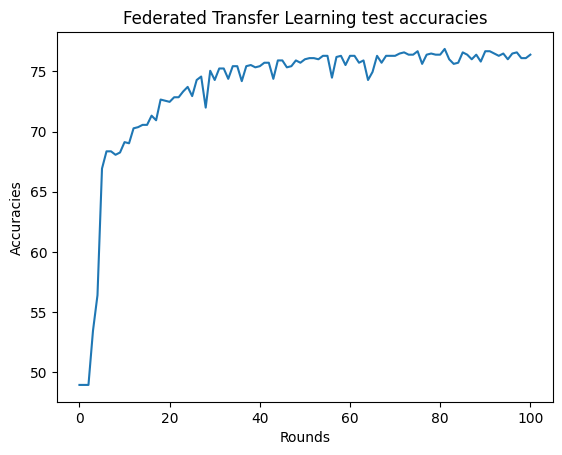

In [13]:
fl_acc
f = []
for i in fl_acc:
    f.append(float(i))
plt.plot(f)
plt.title('Federated Transfer Learning test accuracies')
plt.ylabel('Accuracies')
plt.xlabel('Rounds')